# obtain 2D mass of illustris galaxy from elliptical apertures given by surface brightness profile fit

In [1]:
import numpy as np
import sep
import h5py
import fitsio
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import glob

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [5]:
fits_file="~/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Illustris_0_xy_cen.fits"
data = fitsio.read(fits_file)

pixel_scale = 5. #kpc/px

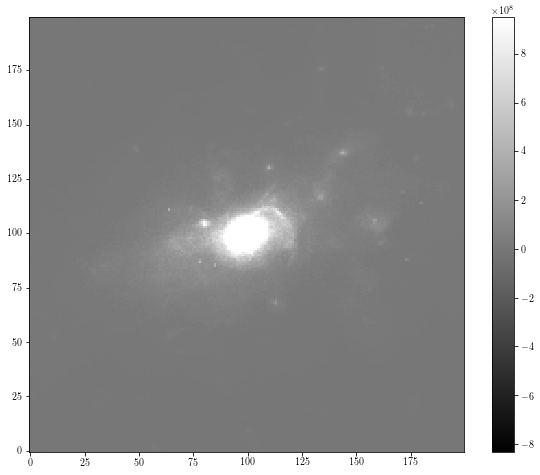

In [6]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

In [7]:
objects = sep.extract(data, 5, clean=False)

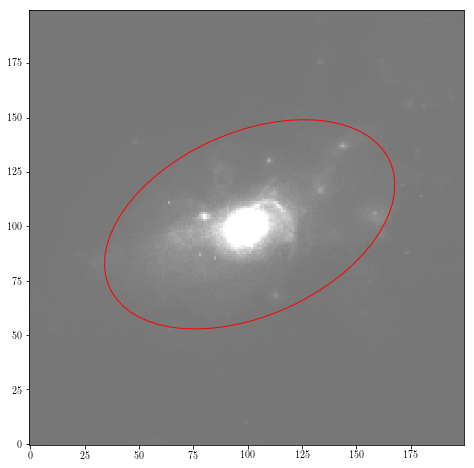

In [8]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
im = ax.imshow(data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=pixel_scale*objects['a'][i],
                height=pixel_scale*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [170]:
flux, fluxerr, flag = sep.sum_ellipse(data, objects['x'], objects['y'], pixel_scale*objects['a'], pixel_scale*objects['b'], objects['theta'])

In [171]:
np.log10(flux)

array([ 12.37192072])

In [172]:
np.log10(objects['flux'])

array([ 12.37459121])

# get ellipse params from sbp profile fit

In [9]:
#open pickels
illustris_pickle='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris.pkl'
tng_pickle='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG.pkl'

pkl = open(illustris_pickle,'rb')  
illustris = pickle.load(pkl)  
pkl.close()

pkl = open(tng_pickle,'rb')  
tng = pickle.load(pkl)  
pkl.close()

In [10]:
def get_masses(array):
    cat_masses=np.array([i[1] for i in array])
    summed_masses=np.array([i[2] for i in array])
    fit_masses=np.array([i[0]['mag_tot'][0]/-2.5 for i in array])
    
    return [cat_masses, summed_masses, fit_masses]

masses_illustris = get_masses(illustris)

In [11]:
isos_illustris=[i[0] for i in illustris]

In [12]:
isos_illustris[0].colnames

['sma',
 'intens',
 'int_err',
 'pix_var',
 'rms',
 'ell',
 'ell_err',
 'pa',
 'pa_err',
 'x0',
 'x0_err',
 'y0',
 'y0_err',
 'grad',
 'grad_err',
 'grad_r_err',
 'rsma',
 'mag',
 'mag_lerr',
 'mag_uerr',
 'tflux_e',
 'tflux_c',
 'tmag_e',
 'tmag_c',
 'npix_e',
 'npix_c',
 'a3',
 'a3_err',
 'b3',
 'b3_err',
 'a4',
 'a4_err',
 'b4',
 'b4_err',
 'ndata',
 'nflag',
 'niter',
 'stop',
 'a_big',
 'sarea',
 'a1',
 'a1_err',
 'b1',
 'b1_err',
 'a2',
 'a2_err',
 'b2',
 'b2_err',
 'col49',
 'col50',
 'col51',
 'col52',
 'col53',
 'col54',
 'col55',
 'col56',
 'pa_norm',
 'sbp_ori',
 'sbp_sub',
 'sbp',
 'intens_sub',
 'intens_bkg',
 'sbp_err',
 'sbp_low',
 'sbp_upp',
 'sma_asec',
 'rsma_asec',
 'growth_ori',
 'growth_sub',
 'avg_x0',
 'avg_y0',
 'avg_q',
 'avg_pa',
 'avg_bkg',
 'intens_cor',
 'sbp_cor',
 'growth_cor',
 'rad_outer',
 'mag_tot',
 'mag_tot_ori',
 'mag_tot_sub']

In [67]:
#find nearest radius bin to 30kpc
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

index_30kpc = find_nearest(isos_illustris[0]['sma'],30.)

In [99]:
e = isos_illustris[0]['ell'][index_30kpc]
pa = isos_illustris[0]['avg_pa'][index_30kpc]* np.pi/180.
x0 = isos_illustris[0]['avg_x0'][index_30kpc]
y0 = isos_illustris[0]['avg_y0'][index_30kpc]
a = isos_illustris[0]['sma'][index_30kpc] #* 2.0
b = isos_illustris[0]['sma'][index_30kpc]* (1.0 - e) #* 2.0

In [94]:
flux, fluxerr, flag = sep.sum_ellipse(data, x0, y0, a, b, pa)

In [73]:
objects['a'], objects['b'], objects['theta']

(array([ 28.2723732]), array([ 16.84010696]), array([ 0.42269731]))

In [75]:
objects['x'], objects['y']

(array([ 100.92169183]), array([ 100.96598408]))

In [95]:
np.log10(flux)

12.224180003468151

In [89]:
print [m[0] for m in masses_illustris]

[12.414851125832998, 12.374591202363039, 12.25783453180728]


## get fits files

In [108]:
files = glob.glob('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Illustris*xy_cen.fits')
len(files)

339

In [122]:
len(masses_illustris[2])

337

In [ ]:
# 337 masses. 339 files (2 failed). need to match by cat mass

In [123]:
cat_masses=masses_illustris[0]

In [128]:
# Load general simulation and galaxy properties
illustris_sim_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_orig_11.2.hdf5'
f = h5py.File(illustris_sim_file, 'r')
cat_sh_mstar = np.array(f['cat_sh_mstar'])
f.close()
log_mstar = np.log10(cat_sh_mstar)

In [137]:
#match cat masses
#9, 142 are missing
indices=[]
for mass in cat_masses:
    index = np.where(log_mstar==mass)[0][0]
    indices.append(index)
    
print indices


[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 22

In [139]:
masses_1d=[]
masses_2d=[]

for i1,i2 in enumerate(indices):
    #i1 is the index within illustris galaxies which successfully fit (0-336)
    #i2 is the index within all illustris files (0-338)
    
    file="~/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Illustris_%d_xy_cen.fits"%(i2)

    
    data = fitsio.read(file)
    
    e = isos_illustris[0]['ell'][index_30kpc]
    pa = isos_illustris[0]['avg_pa'][index_30kpc]* np.pi/180.
    x0 = isos_illustris[0]['avg_x0'][index_30kpc]
    y0 = isos_illustris[0]['avg_y0'][index_30kpc]
    a = isos_illustris[0]['sma'][index_30kpc] #* 2.0
    b = isos_illustris[0]['sma'][index_30kpc]* (1.0 - e) #* 2.0
    flux, fluxerr, flag = sep.sum_ellipse(data, x0, y0, a, b, pa)
    
    mass_2d=np.log10(flux)
    mass_1d=masses_illustris[2][i1]
    
    masses_1d.append(mass_1d)
    masses_2d.append(mass_2d)
    
   

Text(0,0.5,u'2D Mass')

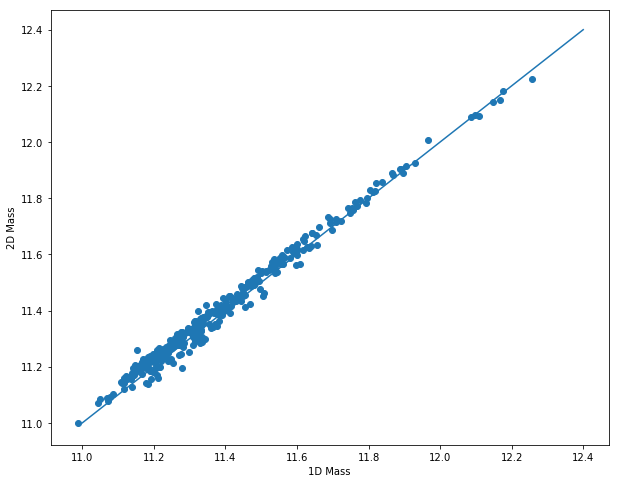

In [144]:
plt.scatter(masses_1d,masses_2d)
plt.plot([11,12.4],[11,12.4])
plt.xlabel('1D Mass')
plt.ylabel('2D Mass')

In [150]:
# append 2d mass to pickle containing all masses

for i in range(len(illustris)):
    mass_2d=masses_2d[i]
    illustris[i].append(mass_2d)
    
#save as pickle
pkl = open('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris.pkl','wb') 
pickle.dump(illustris,pkl)   
pkl.close()

# TNG

In [151]:
files = glob.glob('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/TNG*xy_cen.fits')
len(files)


235

In [156]:
masses_tng = get_masses(tng)
cat_masses=masses_tng[0]

isos_tng=[i[0] for i in tng]

In [154]:
# Load general simulation and galaxy properties
tng_sim_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_tng75_11.2.hdf5'
f = h5py.File(tng_sim_file, 'r')
cat_sh_mstar = np.array(f['cat_sh_mstar'])
f.close()
log_mstar = np.log10(cat_sh_mstar)

In [155]:
#match cat masses
#26, 109 are missing
indices=[]
for mass in cat_masses:
    index = np.where(log_mstar==mass)[0][0]
    indices.append(index)
    
print indices


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223

In [158]:
masses_1d=[]
masses_2d=[]
index_30kpc = find_nearest(isos_tng[0]['sma'],30.)

for i1,i2 in enumerate(indices):
    #i1 is the index within tng galaxies which successfully fit (0-233)
    #i2 is the index within all tng files (0-235)
    
    file="~/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/TNG_%d_xy_cen.fits"%(i2)

    
    data = fitsio.read(file)
    
    e = isos_tng[0]['ell'][index_30kpc]
    pa = isos_tng[0]['avg_pa'][index_30kpc]* np.pi/180.
    x0 = isos_tng[0]['avg_x0'][index_30kpc]
    y0 = isos_tng[0]['avg_y0'][index_30kpc]
    a = isos_tng[0]['sma'][index_30kpc] #* 2.0
    b = isos_tng[0]['sma'][index_30kpc]* (1.0 - e) #* 2.0
    flux, fluxerr, flag = sep.sum_ellipse(data, x0, y0, a, b, pa)
    
    mass_2d=np.log10(flux)
    mass_1d=masses_tng[2][i1]
    
    masses_1d.append(mass_1d)
    masses_2d.append(mass_2d)
    
   

Text(0,0.5,u'2D Mass')

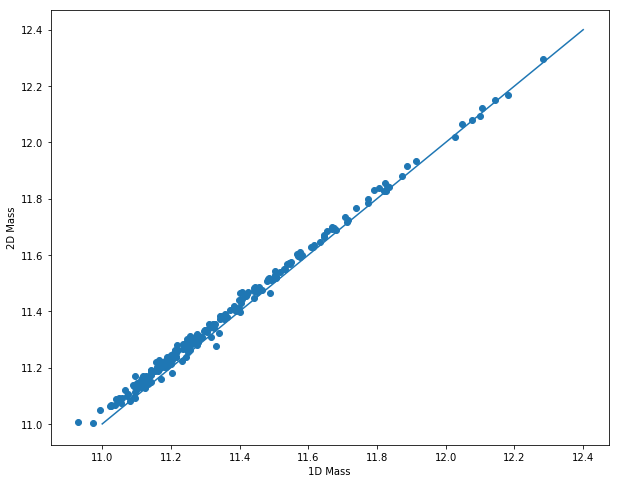

In [159]:
plt.scatter(masses_1d,masses_2d)
plt.plot([11,12.4],[11,12.4])
plt.xlabel('1D Mass')
plt.ylabel('2D Mass')

In [160]:
# append 2d mass to pickle containing all masses

for i in range(len(tng)):
    mass_2d=masses_2d[i]
    tng[i].append(mass_2d)
    
#save as pickle
pkl = open('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG.pkl','wb') 
pickle.dump(tng,pkl)   
pkl.close()

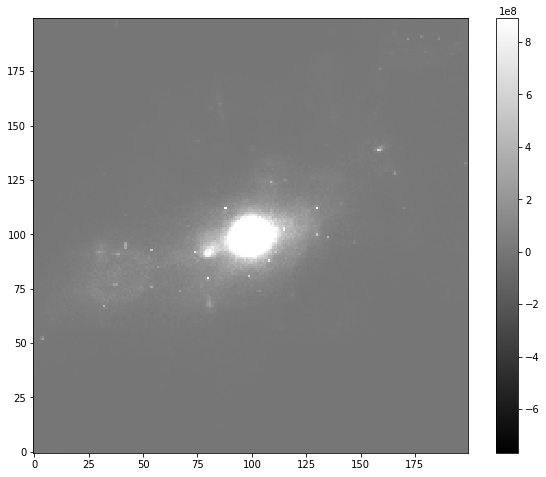

In [161]:
data = fitsio.read("~/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/TNG_0_xy_cen.fits")
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

# Song's suggestions:
```1)  I see you are using the nearest radius bin to estimate the aperture mass from 1-D profiles.  This may not be accurate enough, and typically we use 1-D interpolation to estimate the aperture mass at exact radius.  This is Cell 67. 
2) In the same cell I see you are using `index_30kpc = find_nearest(isos_illustris[0]['sma'],30.)`.  By 30, do you mean 30 pixels or 30 kpc?  30 pixels equal to 150 kpc given the scale of the TNG image.```

```
@felipe I took the liberty to run a few tests my self, using the first 100 galaxies from the file.  What I did is a simplified version of the analysis (yet, it may actually a better approach): 
* Step 1: Estimate the background using `sep` with a very small background box and filter size, this way, most of the diffuse parts of the galaxies will be subtracted out.
* Step 2: Object detection using `sep`, using a relative large Gaussian kernel and very high threshold, make sure the central galaxy is well described.  This can give us the central locations and the average shape of the galaxy (`b/a`, `PA`). 
* Step 3: Derive 2-D aperture masses using sep.sum_ellipse, based on the above galaxy shape.  I do this for  *30, 100, 200 kpc* apertures. 
* Step 4: Run `galSBP` using `step3`, directly use the `sep` shape to derive 1-D surface brightness profiles.  And estimate the 1-D aperture masses using interpolation.
```

## 1D aperture mass through interpolation

In [175]:
iso=isos_illustris[0]

In [176]:
iso[67]

sma,intens,int_err,pix_var,rms,ell,ell_err,pa,pa_err,x0,x0_err,y0,y0_err,grad,grad_err,grad_r_err,rsma,mag,mag_lerr,mag_uerr,tflux_e,tflux_c,tmag_e,tmag_c,npix_e,npix_c,a3,a3_err,b3,b3_err,a4,a4_err,b4,b4_err,ndata,nflag,niter,stop,a_big,sarea,a1,a1_err,b1,b1_err,a2,a2_err,b2,b2_err,col49,col50,col51,col52,col53,col54,col55,col56,pa_norm,sbp_ori,sbp_sub,sbp,intens_sub,intens_bkg,sbp_err,sbp_low,sbp_upp,sma_asec,rsma_asec,growth_ori,growth_sub,avg_x0,avg_y0,avg_q,avg_pa,avg_bkg,intens_cor,sbp_cor,growth_cor,rad_outer,mag_tot,mag_tot_ori,mag_tot_sub
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
63.7735,26520939.52,12232189.0,143695680.0,101608192.0,0.26,0.01832286,-65.68,2.355216,100.0,0.1483275,101.0,0.1284079,-79090120.0,12331166.0,0.1559128,1.889807,-22.05382,0.02021722,0.01984905,1.244239e+12,1.310908e+12,-30.23726,-30.29393,379.0,509.0,0.03282918,0.01259265,0.01457483,0.01164194,-0.01894075,0.01135423,-0.02076895,0.01136081,69,0,1.0,0.0,nan,2.0,-2271369.0,11491817.0,-1273200.0,10598205.0,1276960.0,11097338.0,1779896.0,10933201.0,162433.6,11056502.0,361695.2,10972453.0,-106675.4,11051661.0,-135987.7,10977150.0,-65.68,-18.5589722629,-18.5589722629,-18.5589722629,663023488.0,0.0,0.0198483256315,-18.5788205885,-18.5391239372,63.7735,2.8259213016,1.1757691856e+12,1.1757691856e+12,100.0,101.0,0.74,-65.68,9304206.0,653719282.0,-18.5436282159,1.17225594619e+12,41.9069136614,-30.6445863295,-30.6765340873,-30.6765340873


In [181]:
np.log10(np.interp(100,iso['sma'], iso['growth_ori']))

12.147816102548923

In [182]:
np.log10(iso['growth_ori'][find_nearest(iso['sma'],100)])

12.146103739668465

In [38]:
def oneD_mass(galaxy_iso, radius_pixels):
    mass=np.interp(radius_pixels,galaxy_iso['sma'], galaxy_iso['growth_ori'])
    return np.log10(mass)

In [185]:
oneD_mass(iso,100)

12.147816102548923

### Step 1: Estimate the background using `sep` with a very small background box and filter size, this way, most of the diffuse parts of the galaxies will be subtracted out.

In [23]:
fits_file = "/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Illustris_0_xy_cen.fits"
data = fitsio.read(fits_file)

pixel_scale = 5. #kpc/px

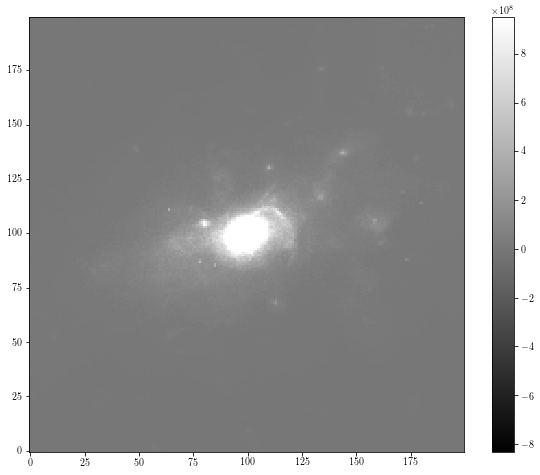

In [14]:
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

In [35]:
bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)

# Subtract the background from the data
bkg_subtraced_data = data - bkg

### Step 2: Object detection using `sep`, using a relative large Gaussian kernel and very high threshold, make sure the central galaxy is well described.  This can give us the central locations and the average shape of the galaxy (`b/a`, `PA`). 

In [36]:
thresh = 500 * bkg.globalrms
objects = sep.extract(bkg_subtraced_data, thresh, clean=False)
#objects = sep.extract(bkg_subtraced_data, 20.0, err=bkg.globalrms, minarea=1000, deblend_nthresh=24, deblend_cont=0.1)


theta = objects['theta'][0]
q = objects['b'][0] / objects['a'][0]

a_30 = (30. / pixel_scale)
b_30 = a_30 * q

a_100 = (100. / pixel_scale)
b_100 = a_100 * q

a_200 = (200. / pixel_scale)
b_200 = a_200 * q

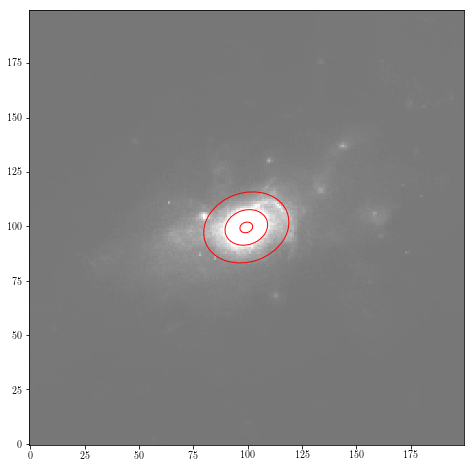

In [37]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
im = ax.imshow(data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e_30 = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=a_30,
                height=b_30,
                angle=theta * 180. / np.pi)
    e_30.set_facecolor('none')
    e_30.set_edgecolor('red')
    ax.add_artist(e_30)
    
    e_100 = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=a_100,
                height=b_100,
                angle=theta * 180. / np.pi)
    e_100.set_facecolor('none')
    e_100.set_edgecolor('red')
    ax.add_artist(e_100)
    
    e_200 = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=a_200,
                height=b_200,
                angle=theta * 180. / np.pi)
    e_200.set_facecolor('none')
    e_200.set_edgecolor('red')
    ax.add_artist(e_200)

### Step 3: Derive 2-D aperture masses using sep.sum_ellipse, based on the above galaxy shape.  I do this for  *30, 100, 200 kpc* apertures. 

In [18]:
flux_30, fluxerr_30, flag_30 = sep.sum_ellipse(data, objects['x'], objects['y'], 
                                     a_30, b_30, theta)

In [19]:
np.log10(flux_30)

array([ 11.94740658])

### Step 4: Run `galSBP` using `stage 3`, directly use the `sep` shape to derive 1-D surface brightness profiles.  And estimate the 1-D aperture masses using interpolation.

In [1]:
import sep
import h5py
import numpy as np
#from functions import *

import os


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)


from astropy.modeling import models, fitting

#---------------------------------------------------------------------------#
#User imports
import sys
sys.path.append('/Users/fardila/Documents/Github/kungpao')
from kungpao.galsbp import galSBP
from kungpao.display import display_single, random_cmap

###############################################################################
#SETUP IRAF STUFF
# For Kungpao
x_images = '/Users/fardila/anaconda/envs/hsc_hydro/iraf/bin.macosx/x_images.e'
x_ttools = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/tables/bin.macosx/x_ttools.e'
x_isophote = '/Users/fardila/anaconda/envs/hsc_hydro/iraf_extern/stsdas/bin.macosx/x_isophote.e'
#---------------------------------------------------------------------------#

#---------------------------------------------------------------------------#
# About the Colormaps
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = random_cmap(ncolors=512, background_color=u'white')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

from pyraf import iraf

iraf.tables()
iraf.stsdas()
iraf.analysis()
iraf.isophote()

iraf.unlearn('ellipse')
iraf.unlearn('bmodel')


Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |    
      |                  TABLES Version 3.17                       |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         

In [24]:
stage=3

iso_3, iso_3_bin = galSBP.galSBP(fits_file,
                                 galX=objects['x'],
                                 galY=objects['y'],
                                 galQ=q,
                                 galPA=theta,
                                 maxSma=250,
                                 iniSma=50.0,
                                 stage=3,
                                 intMode='median',
                                 ellipStep=0.05,
                                 pix=pixel_scale,
                                 zpPhoto=0.0,
                                 harmonics='1 2 3 4',
                                 isophote=x_isophote,
                                 xttools=x_ttools,
                                 recenter=True,
                                 savePng=False,
                                 verbose=True)

----------------------------------------------------------------------------------------------------
###      galX, galY :  [ 99.36358091] [ 99.52657853]
###      galR :  20.0
###      iniSma, maxSma :  50.0 250
###      Stage :  3
###      Step :  0.05
----------------------------------------------------------------------------------------------------
##       Set up the Ellipse configuration
----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
##       Start the Ellipse Run: Attempt  1
----------------------------------------------------------------------------------------------------
###      Origin Image  : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Illustris_0_xy_cen.fits
###      Input Image   : temp_69FRF.fits
###      Output Binary : /Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Illustris_0_x

/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1619: RuntimeWarning: divide by zero encountered in log10
  expTime))
/Users/fardila/Documents/Github/kungpao/kungpao/galsbp/galSBP.py:1619: RuntimeWarning: invalid value encountered in log10
  expTime))


In [27]:
oneD_mass(iso_3, 30./pixel_scale)

11.906191049013001

In [28]:
np.log10(flux_30)

array([ 11.94740658])

In [30]:
oneD_mass(isos_illustris[0], 30.)

11.912031383621617

# Object detetion

In [30]:
from matplotlib.patches import Ellipse

In [2]:
Illustris_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_orig_11.2.hdf5'
TNG_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_tng75_11.2.hdf5'


In [65]:
def detect_objects(sim_file, sim_name, gal_n=0):

    # Load general simulation and galaxy properties
    f = h5py.File(sim_file, 'r')
    cat_sh_mstar = np.array(f['cat_sh_mstar'])

    map_stars_insitu = np.array(f['map_stars_insitu'])
    map_stars_exsitu = np.array(f['map_stars_exsitu'])
    map_stars = map_stars_exsitu + map_stars_insitu

    map_size = f.attrs['stellar_map_size']
    n_pixels = f.attrs['stellar_map_np']

    pixel_scale=2 * (map_size/n_pixels)
    f.close()

    #make maps
    img_cen = map_stars[gal_n, 0, 1] * (pixel_scale ** 2) # Central
    img_sat = map_stars[gal_n, 1, 1] * (pixel_scale ** 2) # Satellites
    img_icl = map_stars[gal_n, 2, 1] * (pixel_scale ** 2) # Diffuse
    img_cen_sat = (img_cen + img_sat)           # Central + Satellites
    img_cen_icl = (img_cen + img_icl)           # Central + Satellites
    img_all = (img_cen + img_sat + img_icl)           # Central + Satellites + Diffuse

    #convert the image into unit of stellar mass instead of mass density
    m_cat = np.log10(cat_sh_mstar[gal_n])
    m_post = np.log10(np.sum(img_cen))
    m_post_icl = np.log10(np.sum(img_cen_icl))

    #ouput maps
    maps_location='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/'
    file_name=sim_name+'_'+str(gal_n)+'_xy'
    fits_prefix = maps_location + file_name

    data=img_cen
    suffix='_cen'

    ###########################################################################
    #get background
    bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)
    bkg_subtraced_data = data - bkg

    thresh = 500 * bkg.globalrms
    objects = sep.extract(bkg_subtraced_data, thresh, minarea = 100,
                          deblend_nthresh=24, deblend_cont=0.1)

    #find object closest to image center
    obj = find_closest(objects)

    #ellipse parameters
    theta = obj['theta'][0]
    q = obj['b'][0] / obj['a'][0]

    a_10, a_30, a_100 = (10. / pixel_scale), (30. / pixel_scale), (100. / pixel_scale)
    b_10, b_30, b_100 =  a_10 * q, a_30 * q, a_100 * q



    # plot background-subtracted image
    m, s = np.mean(data), np.std(data)
    fig, ax = plt.subplots()
    im = ax.imshow(data, interpolation='nearest', cmap=plt.get_cmap('viridis'),
                   vmin=m-s, vmax=m+s, origin='lower')

    # plot an ellipse for each object
    e_30 = Ellipse(xy=(obj['x'][0], obj['y'][0]),
                 width=a_30,
                 height=b_30,
                 angle=theta * 180. / np.pi)
    e_30.set_facecolor('none')
    e_30.set_edgecolor('red')
    ax.add_artist(e_30)

    e_100 = Ellipse(xy=(obj['x'][0], obj['y'][0]),
                 width=a_100,
                 height=b_100,
                 angle=theta * 180. / np.pi)
    e_100.set_facecolor('none')
    e_100.set_edgecolor('red')
    ax.add_artist(e_100)
    
    
    plt.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/ellipses/'+file_name)
    plt.show()
    
    flux_30, fluxerr_30, flag_30 = sep.sum_ellipse(data, 100., 100.,
                                                   a_30, b_30, theta)
    
    print flux_30

(array([-0.13393654]), array([ 2.13987446]), array([ 2.85345578]))


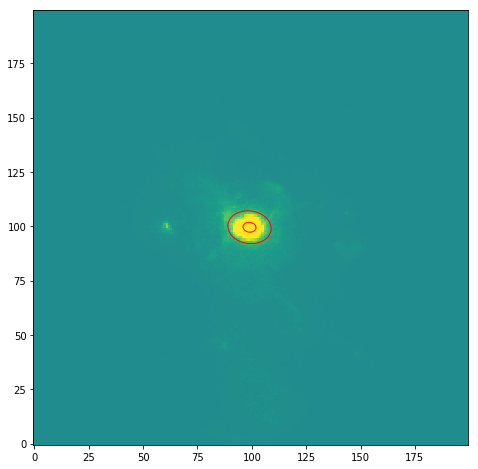

4.08104435392e+11


In [44]:
i=12
detect_objects(Illustris_file,'Illustris',gal_n=i)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 0^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 0.34128621]), array([ 2.254632]), array([ 2.84894967]))


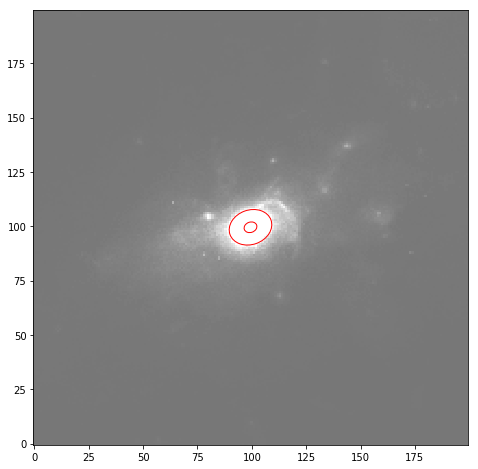

8.85339856543e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 1^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 0.47432315]), array([ 1.84566987]), array([ 2.04790688]))


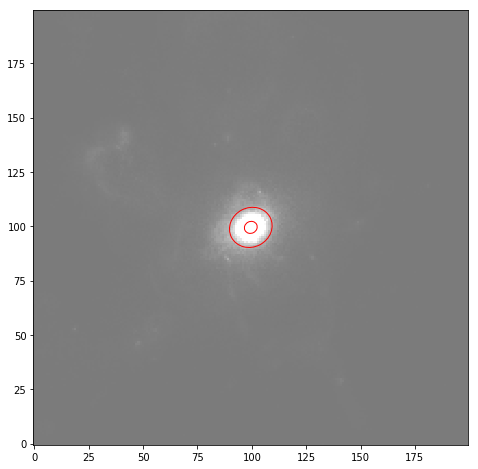

6.70904074388e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 2^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 1.32097983]), array([ 2.16197324]), array([ 3.07665181]))


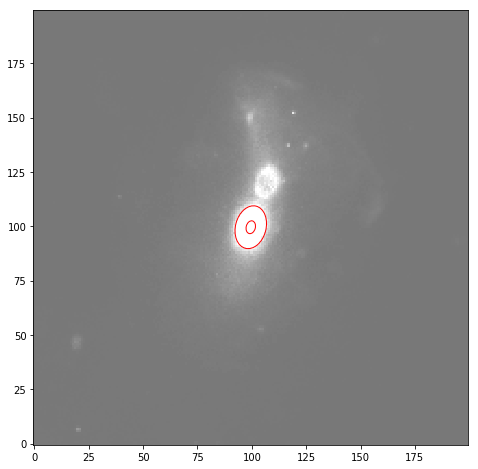

7.42254660833e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 3^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 0.73481619]), array([ 2.26694775]), array([ 3.34694171]))


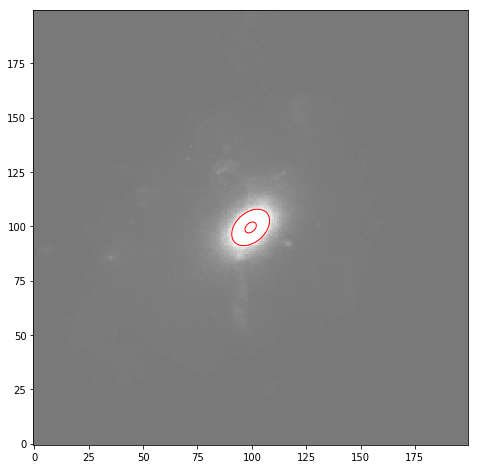

8.92141047322e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 4^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 1.50100887]), array([ 2.23950887]), array([ 3.7804091]))


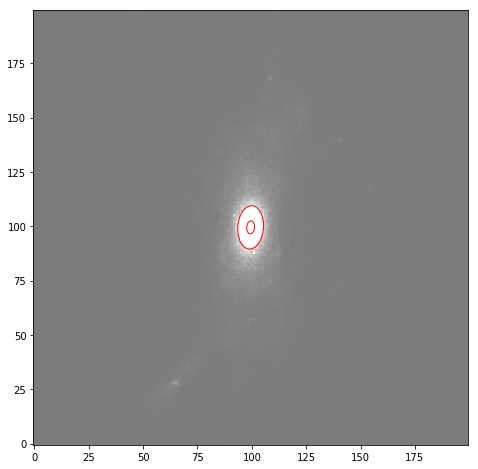

4.87006482803e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 5^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 0.24892202]), array([ 2.00949454]), array([ 2.38114405]))


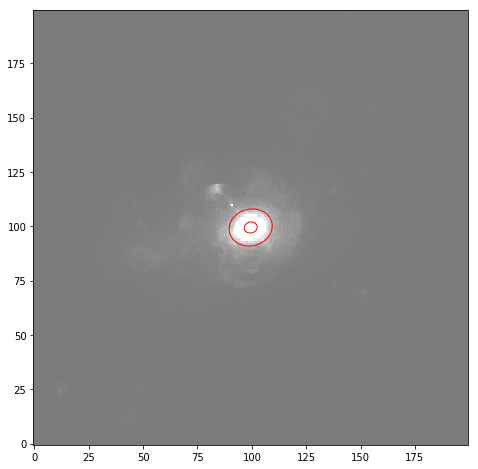

5.12291735154e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 6^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 0.41491055]), array([ 2.67898202]), array([ 13.85166931]))


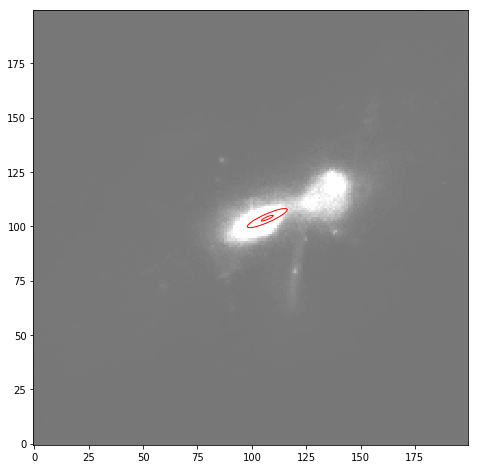

3.71889931049e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 7^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 1.41607106]), array([ 1.6254133]), array([ 2.24299049]))


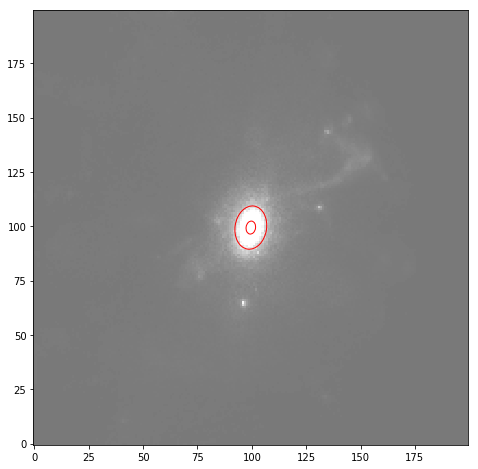

4.66542274488e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 8^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-0.66664022]), array([ 2.46061921]), array([ 3.20485759]))


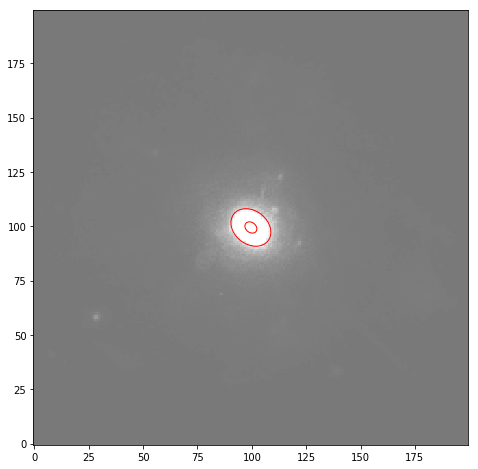

7.19838125768e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 9^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 1.42227101]), array([ 1.98343217]), array([ 3.80068827]))


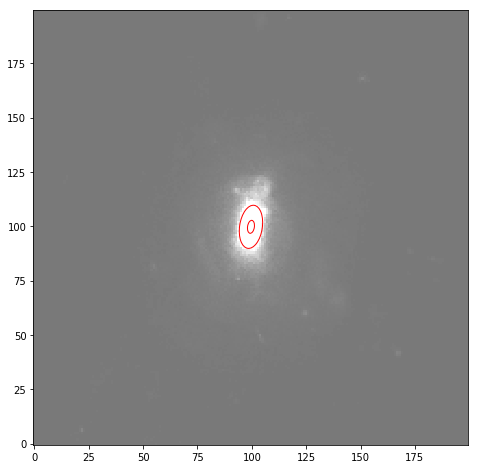

6.19724330445e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 10^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 1.27254379]), array([ 2.85330105]), array([ 4.32800198]))


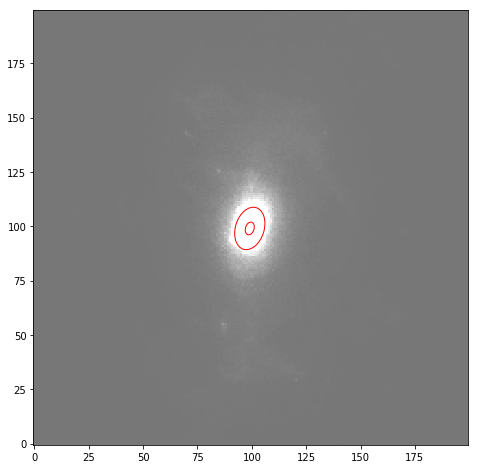

7.14235459267e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 11^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-1.39497447]), array([ 2.52819037]), array([ 4.07511044]))


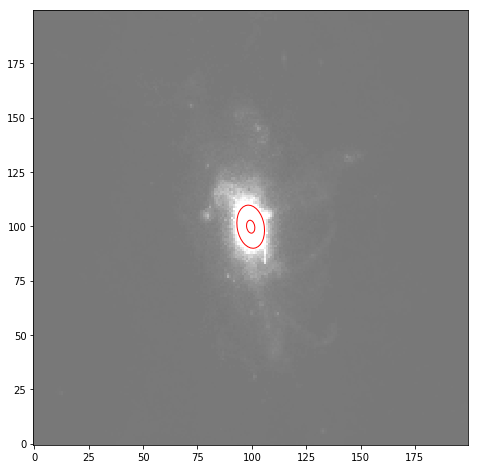

3.02434285135e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 12^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-0.13393654]), array([ 2.13987446]), array([ 2.85345578]))


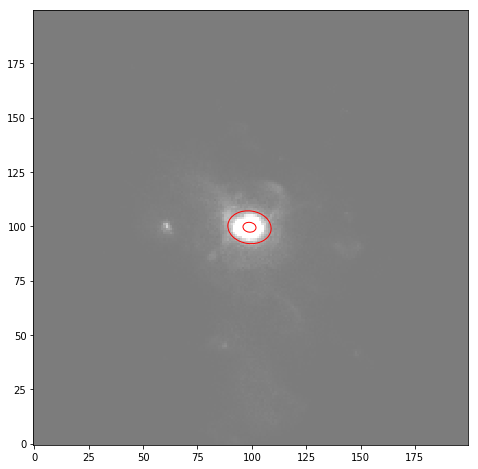

4.08104435392e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 13^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-1.23034525]), array([ 2.23697901]), array([ 2.68577552]))


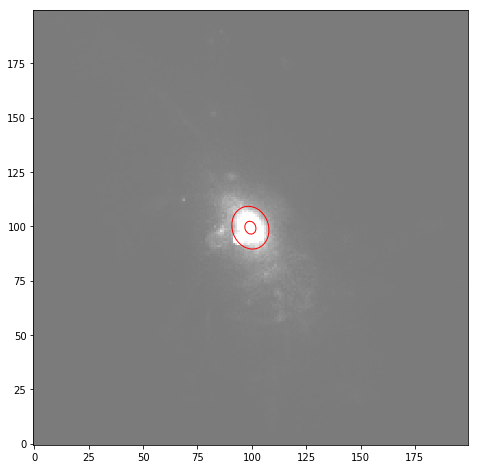

4.81613453444e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 14^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 0.72372317]), array([ 2.13012457]), array([ 2.52682066]))


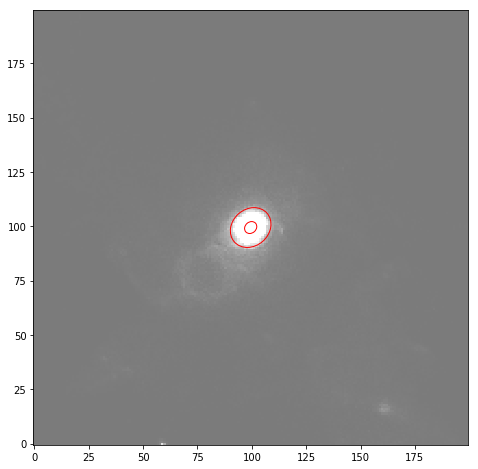

3.79716248748e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 15^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-0.89832604]), array([ 1.89491177]), array([ 2.02423263]))


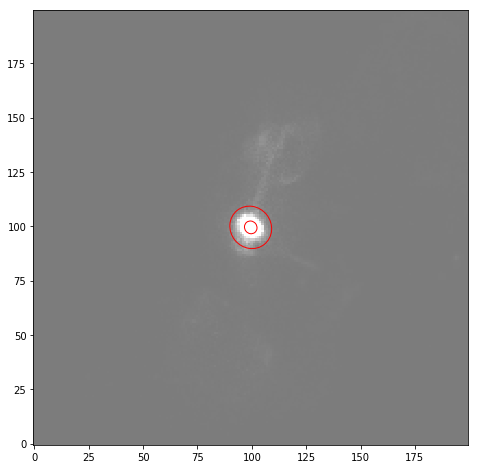

2.455052099e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 16^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 1.06210613]), array([ 2.42456007]), array([ 3.9375751]))


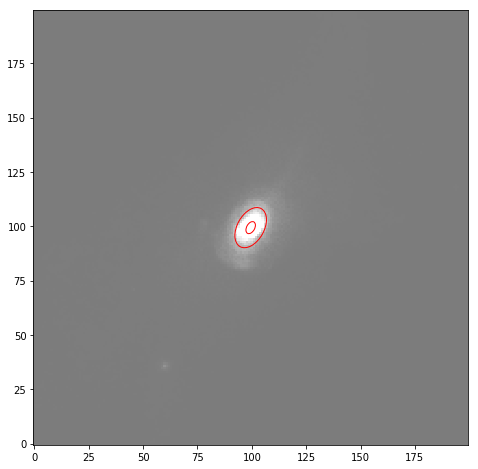

5.88544528783e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 17^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-0.0883894]), array([ 1.65033603]), array([ 2.36154461]))


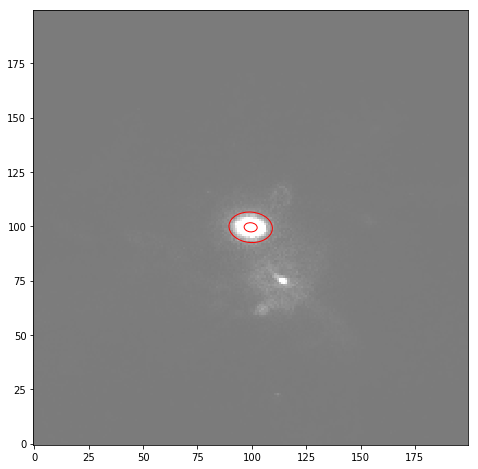

2.71632033331e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 18^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-0.52007073]), array([ 1.81108034]), array([ 3.42650223]))


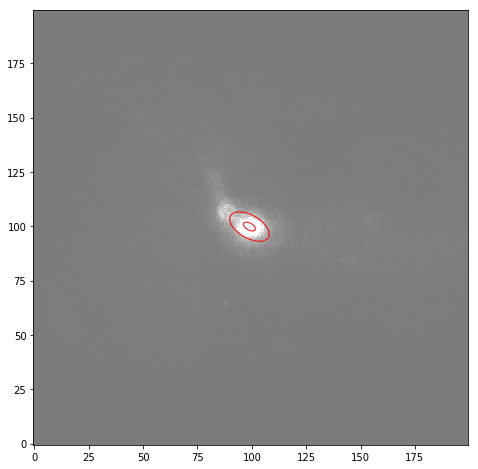

1.71519928376e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 19^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-1.37227452]), array([ 1.77068126]), array([ 1.82314885]))


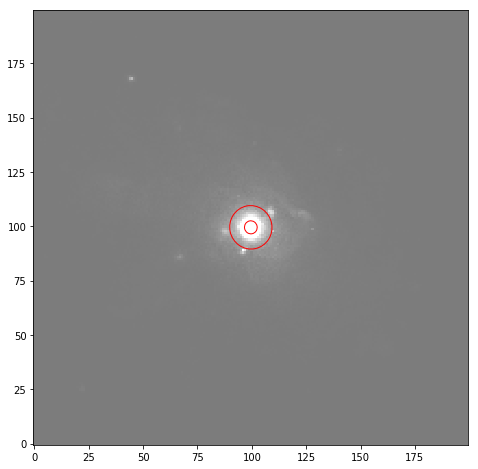

3.75355328357e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 20^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-0.63659859]), array([ 3.20411372]), array([ 3.30777764]))


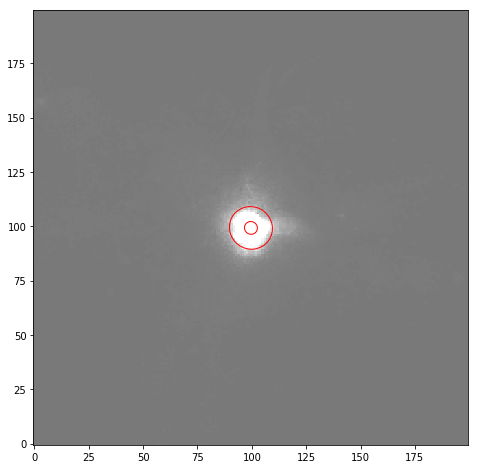

2.93879031348e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 21^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-1.15575325]), array([ 2.15607047]), array([ 3.37981033]))


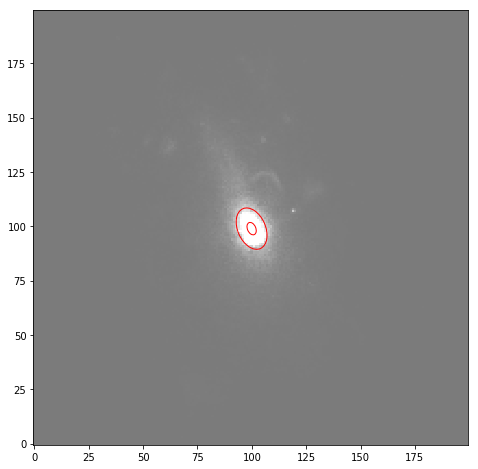

2.70724309582e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 22^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-0.67143875]), array([ 2.41831541]), array([ 8.40108776]))


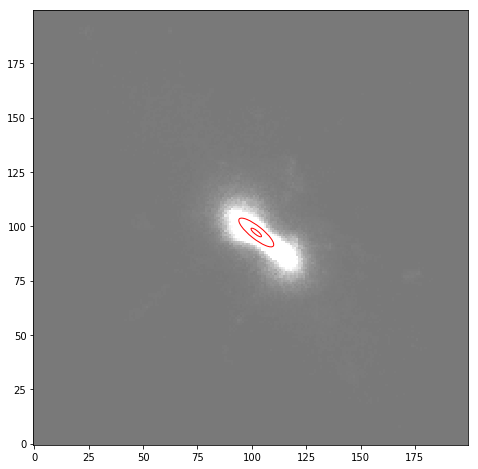

1.98443509955e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 23^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([ 1.17064917]), array([ 2.40281081]), array([ 3.16560936]))


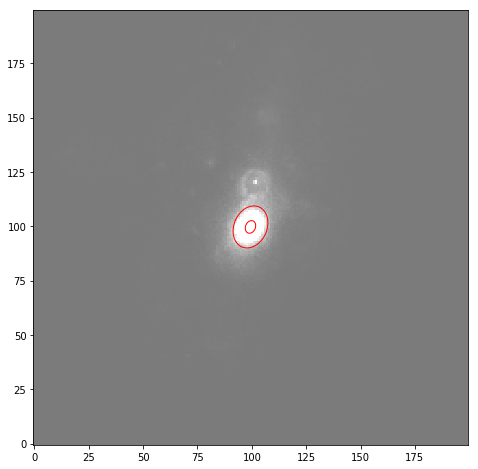

4.04707716652e+11
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^GALAXY 24^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(array([-0.46821797]), array([ 3.12486839]), array([ 5.408638]))


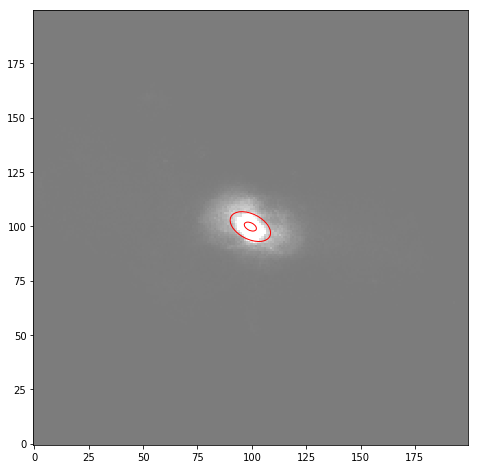

4.50395203104e+11


In [24]:
for i in range(25):
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^GALAXY '+str(i)+'^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')

    detect_objects(Illustris_file,'Illustris',gal_n=i)

In [51]:
fits_file="~/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/Illustris_65_xy_cen.fits"
data = fitsio.read(fits_file)

In [52]:
bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)
bkg_subtraced_data = data - bkg

thresh = 500 * bkg.globalrms
objects = sep.extract(bkg_subtraced_data, thresh, minarea = 100, deblend_nthresh=24, 
                            deblend_cont=0.1)

In [53]:
objects

array([ ( 3912554.75,  153,  141, 64,  77, 56,  71,  70.00238201,  63.61062333,   4.74696051,   7.03534318,  0.8992577 ,  0.,  0.,  0.,  2.71043015,  2.1061511,  1.23774409,  0.21588865,  0.14566666, -0.05518978,   5.37744640e+09,   5.42185779e+09,   1.46721232e+08,   2.20034656e+08, 70,  62, 70,  62, 0),
       ( 3912554.75, 1522, 1433, 66, 127, 77, 140,  99.56815621,  99.76909673,  11.47059116,  17.24384539, -2.60957324,  0.,  0.,  0.,  4.27183247,  3.2351017, -1.20328009,  0.09028795,  0.06005947,  0.0273272 ,   3.38409128e+11,   3.38588107e+11,   1.41775247e+10,   2.00554742e+10, 99, 100, 99, 100, 0)],
      dtype=[('thresh', '<f8'), ('npix', '<i8'), ('tnpix', '<i8'), ('xmin', '<i8'), ('xmax', '<i8'), ('ymin', '<i8'), ('ymax', '<i8'), ('x', '<f8'), ('y', '<f8'), ('x2', '<f8'), ('y2', '<f8'), ('xy', '<f8'), ('errx2', '<f8'), ('erry2', '<f8'), ('errxy', '<f8'), ('a', '<f8'), ('b', '<f8'), ('theta', '<f8'), ('cxx', '<f8'), ('cyy', '<f8'), ('cxy', '<f8'), ('cflux', '<f8'), ('flux', '<f

In [63]:
def find_closest(objects, x0=100., y0=100.):
    xs=objects['x']
    ys=objects['y']
    distances=np.sqrt(((xs-x0)**2) + ((ys-y0)**2))
    
    closest_index=np.argmin(distances)
    
    return objects[closest_index]
    

In [64]:
object=find_closest(objects)
print object

( 3912554.75, 1522, 1433, 66, 127, 77, 140,  99.56815621,  99.76909673,  11.47059116,  17.24384539, -2.60957324,  0.,  0.,  0.,  4.27183247,  3.2351017, -1.20328009,  0.09028795,  0.06005947,  0.0273272,   3.38409128e+11,   3.38588107e+11,   1.41775247e+10,   2.00554742e+10, 99, 100, 99, 100, 0)
